In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import itertools as iter

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)


2023-08-23 16:47:47.303999: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 16:47:47.762761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/MonetGAN


2023-08-23 16:47:48.674369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 16:47:48.694296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 16:47:48.694642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Dataset

In [2]:
allFiles=[]
for root, dirs, files in os.walk(os.path.join(DATA_PATH, "processed")):
    for f in files:
        allFiles.append(os.path.join(root, f))

In [3]:
images=[]
for i,file in enumerate(tqdm(allFiles)):
    with Image.open(file) as im:
        images.append(np.array(im))

  0%|          | 0/1884 [00:00<?, ?it/s]

In [4]:
T=100
beta = np.linspace(1e-4, 0.02, T)
alpha = 1-beta
alphaBar = [np.prod(alpha[0:i+1]) for i,el in enumerate(alpha)]
IMAGE_SIZE = [256,256]
tValues = np.arange(0,T)
# alphaBar = np.cos((tValues/(T+1) + 0.008)/(1 + 0.008) * np.pi/2) 
np.random.shuffle(tValues)

def forwardStep(x0,t):
    noise = np.random.normal(0, 1, x0.shape)
    noisy = np.sqrt(alphaBar[t])*x0 + np.sqrt(1-alphaBar[t])*noise
    return noise, noisy

def generator():
    for i,file in enumerate(images):
        # image = tf.io.read_file(file)
        # image = tf.io.decode_jpeg(image, channels=3)
        image = tf.convert_to_tensor(file)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.95, 1.05)
        image = (tf.cast(image, tf.float32) / 127.5) - 1
        x0 = image.numpy()
        for t in tValues:
            noise, noisy = forwardStep(x0, t)
            yield noisy, noise, [t]

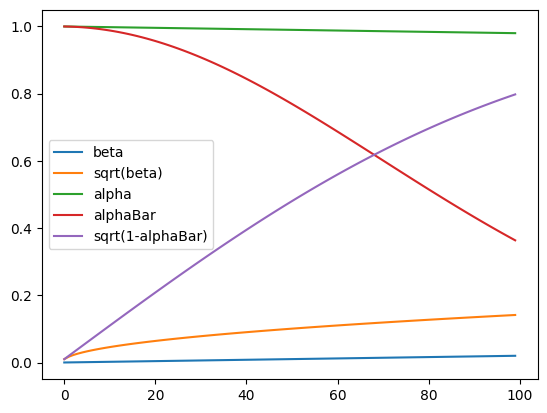

In [5]:
_ = plt.plot(beta, label="beta")
_ = plt.plot(np.sqrt(beta), label="sqrt(beta)")
_ = plt.plot(alpha, label="alpha")
_ = plt.plot(alphaBar, label="alphaBar")
_ = plt.plot(np.sqrt(1-np.array(alphaBar)[np.arange(0,T)]), label="sqrt(1-alphaBar)")
_ = plt.legend()

In [6]:
g = generator()
test = next(g)
print(test[2])
print(test[0].shape)
print(test[1].shape)

[43]
(256, 256, 3)
(256, 256, 3)


2023-08-23 16:47:53.118008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 16:47:53.118455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 16:47:53.118816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 16:47:53.553659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 16:47:53.554066: I tensorflow/compile

In [7]:
test = next(g)
np.max(test[0])

1.3543288156207434

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65]


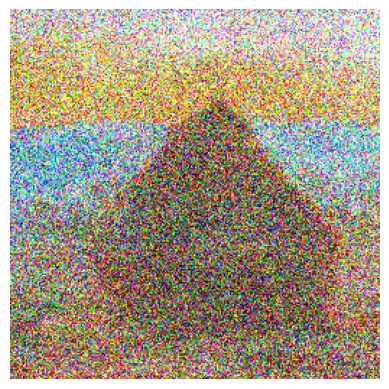

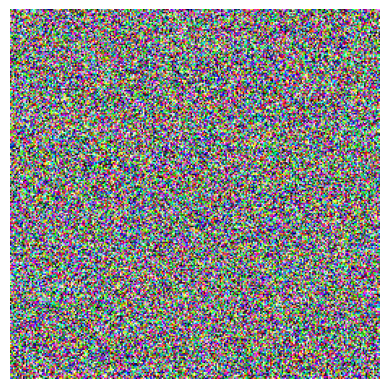

In [8]:
test = next(g)
plt.imshow((test[0]+1)/2)
plt.axis('off')
plt.figure()
plt.imshow((test[1]+1)/2)
plt.axis('off')
print(test[2])

## Testing of the forward and backward process

Test the denoising steps all at one (what the neural network should predict gradually)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

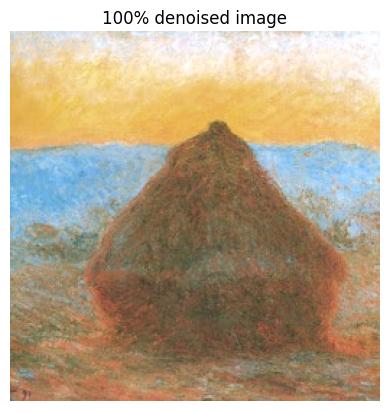

In [9]:
testDenoised = (test[0] - np.sqrt(1-alphaBar[test[2][0]])*test[1])/np.sqrt(alphaBar[test[2][0]])
plt.imshow((testDenoised+1)/2)
plt.title("100% denoised image")
plt.axis('off')

Forward pass

In [10]:
noisyImages=[]
noises=[]
x0=images[0]/127.5-1
for tStep in range(80):
    noise, noisy = forwardStep(x0, tStep)
    noisyImages.append(noisy)
    noises.append(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


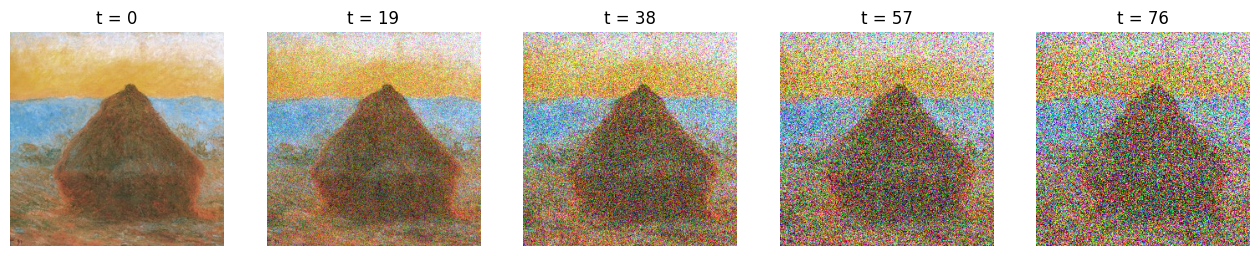

In [11]:
plt.figure(figsize=(16,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(noisyImages[i*19]/2+0.5)
    plt.axis("off")
    plt.title("t = "+str(i*19))

Backward pass

In [12]:
samples = [noisyImages[-1]]
predNoises = [noises[-1]]

def backwardStep(xt, predNoise, t):

    x0Pred=(xt - np.sqrt(1-alphaBar[t])*predNoise)/np.sqrt(alphaBar[t])

    if t==0:
        sample = x0Pred
        noise= np.zeros(xt.shape)
    else:
        # estimate mean
        meanPred= x0Pred * (np.sqrt(alphaBar[t])*beta[t])/((1-alphaBar[t])*np.sqrt(alpha[t])) + xt*(alpha[t]-alphaBar[t])/((1-alphaBar[t])*np.sqrt(alpha[t]))

        # compute variance
        betaPred = np.sqrt(beta[t])

        sample = meanPred + betaPred*np.random.normal(0,1,xt.shape)

        noise=(sample-x0Pred*np.sqrt(alphaBar[t-1]))/np.sqrt(1-alphaBar[t-1])

    return sample, noise

for t in np.arange(0,80)[::-1]:
    predNoise = predNoises[-1]
    xt = samples[-1]

    sample, noise = backwardStep(xt, predNoise, t)

    samples.append(sample)
    predNoises.append(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


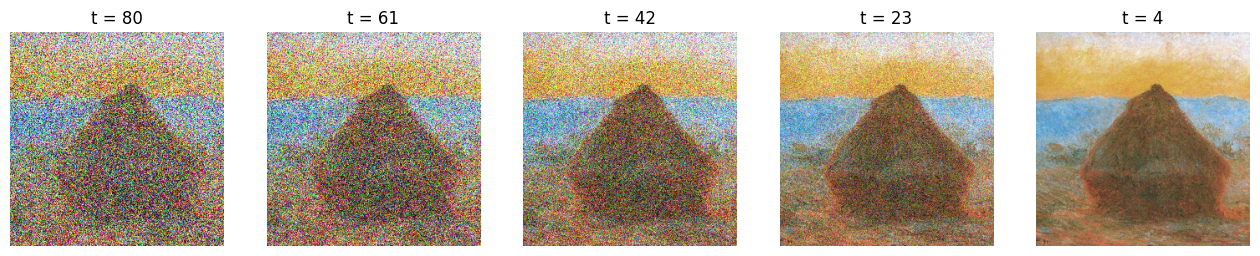

In [13]:
plt.figure(figsize=(16,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(samples[i*19]/2+0.5)
    plt.axis("off")
    plt.title("t = "+str(80-i*19))

In [14]:
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(1), dtype=tf.int32)))
# list(dataset.take(1))[0]

## Tensorflow

In [15]:
%load_ext tensorboard


Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_29 (Embedding)    (None, 1, 256)               25600     ['input_30[0][0]']            
                                                                                                  
 tf.repeat_9 (TFOpLambda)    (None, 1, 256)               0         ['embedding_29[0][0]']        
                                                                                                  
 input_29 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                               

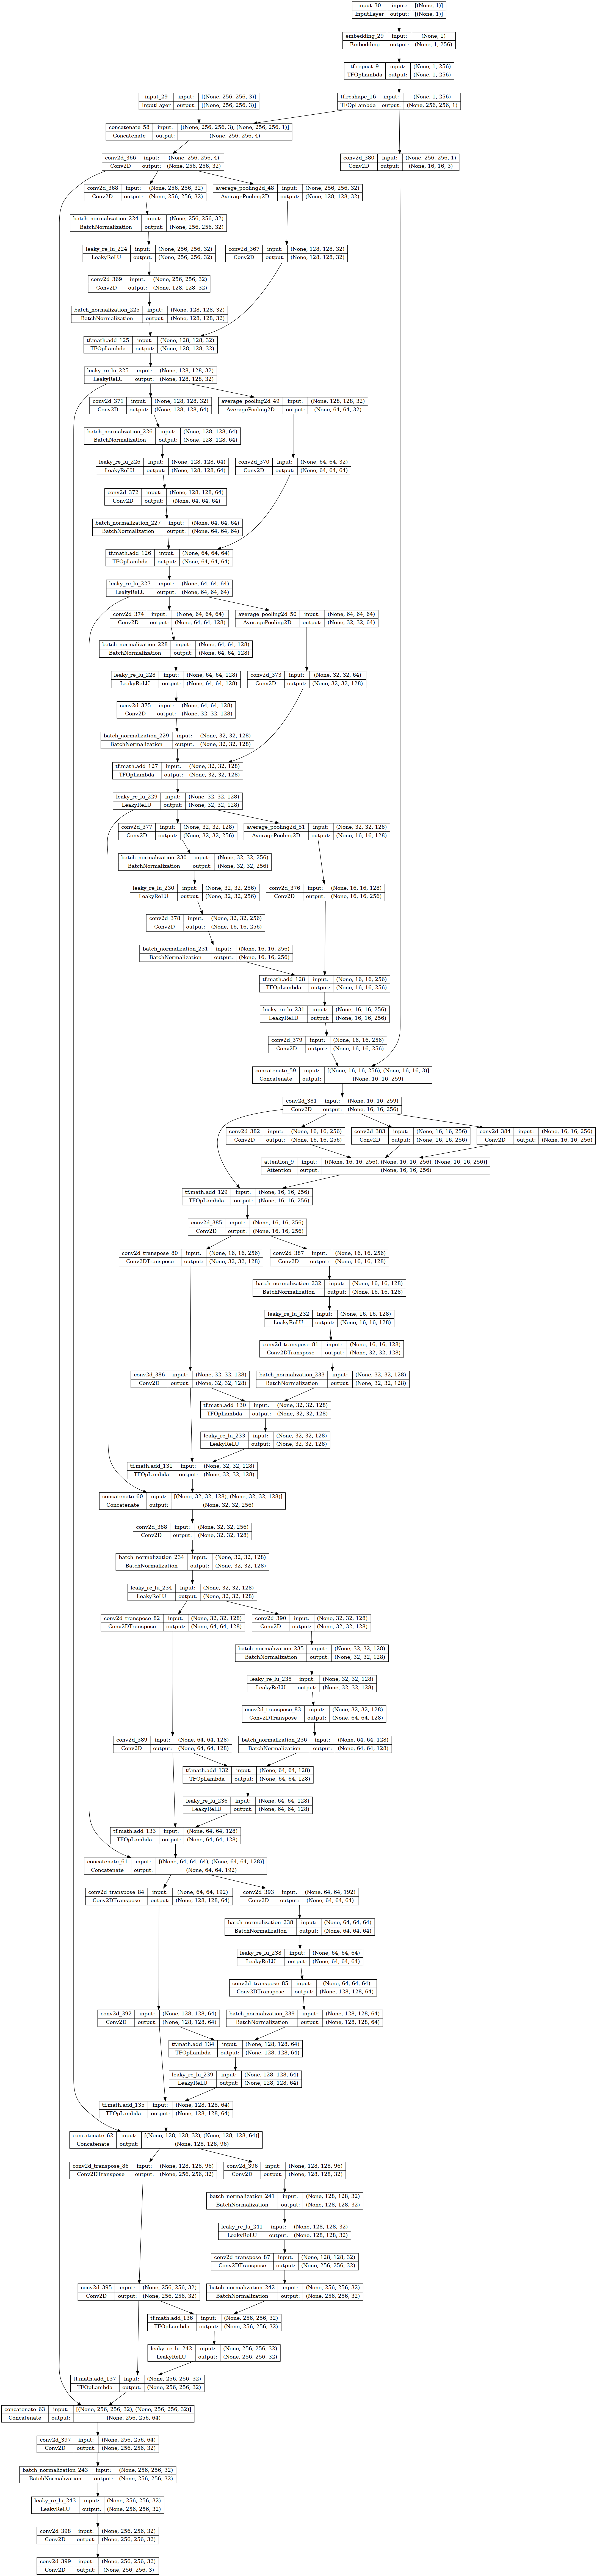

In [59]:
L2=0.0

def downscaleBlock(xIn, ch, filtersize):
    xRes = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(xIn)
    xRes = tf.keras.layers.Conv2D(ch, 1,  padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xRes)

    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.LeakyReLU()(x)
    # x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", strides=2, kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    added = tf.math.add(x, xRes)
    x = tf.keras.layers.LeakyReLU()(added)
    
    return x


def upscaleBlock(xIn, ch, filtersize):
    # xRes = tf.keras.layers.UpSampling2D(size=(2, 2))(xIn)
    xRes = tf.keras.layers.Conv2DTranspose(ch, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    xRes = tf.keras.layers.Conv2D(ch, 1, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(xRes)

    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.LeakyReLU()(x)
    # x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(ch, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    added = tf.math.add(x, xRes)
    x = tf.keras.layers.LeakyReLU()(added)

    return tf.math.add(x, xRes)


def nonLocalBlock(xIn, ch, filtersize=1):
    theta = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    phi = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    g = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    out = tf.keras.layers.Attention()([theta, phi, g])
    return tf.math.add(xIn, out)

def createUnet():
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    embeddedStep = tf.keras.layers.Embedding(T, 256)(stepInput)
    stepMap = tf.repeat(embeddedStep, 256, axis=0)
    stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))

    concatInput = tf.keras.layers.Concatenate()([inputs, stepMap])

    xDown2 = tf.keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(concatInput)
    
    xDown4 = downscaleBlock(xDown2, 32, 3)
    #128

    xDown8 = downscaleBlock(xDown4, 64, 3)
    #64

    xDown16 = downscaleBlock(xDown8 ,128, 3)
    #32

    xDown32 = downscaleBlock(xDown16 ,256, 3)
    #16x16

    xCenter = tf.keras.layers.Conv2D(256, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown32)

    stepMap16 = tf.keras.layers.Conv2D(3, 3, strides=16, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(stepMap)
    concatCenter = tf.keras.layers.Concatenate()([xCenter, stepMap16])

    xCenter = tf.keras.layers.Conv2D(256, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(concatCenter)
    xCenter = nonLocalBlock(xCenter, 256)
    xCenter = tf.keras.layers.Conv2D(256, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xCenter)
    #16x16

    xUp16 = upscaleBlock(xCenter, 128, 3)
    #32x32
    xConcat16 = tf.keras.layers.Concatenate()([xUp16, xDown16])
    xUp16=tf.keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xConcat16)
    xUp16 = tf.keras.layers.BatchNormalization()(xUp16)
    xUp16 = tf.keras.layers.LeakyReLU()(xUp16)

    xUp8 = upscaleBlock(xUp16, 128, 3)
    #64
    xConcat8 = tf.keras.layers.Concatenate()([xDown8, xUp8])
    xUp8=tf.keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xConcat8)
    xUp8 = tf.keras.layers.BatchNormalization()(xUp8)
    xUp8 = tf.keras.layers.LeakyReLU()(xUp8)

    xUp4 = upscaleBlock(xConcat8, 64, 3)
    #128
    xConcat4 = tf.keras.layers.Concatenate()([xDown4, xUp4])
    xUp4=tf.keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xConcat4)
    xUp4 = tf.keras.layers.BatchNormalization()(xUp4)
    xUp4 = tf.keras.layers.LeakyReLU()(xUp4)

    xUp2 = upscaleBlock(xConcat4, 32, 3)
    #256
    xConcat2 = tf.keras.layers.Concatenate()([xDown2, xUp2])
    
    x=tf.keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xConcat2)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x=tf.keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    outputs=tf.keras.layers.Conv2D(3, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="unet")


model = createUnet()

model.summary()

dot_img_file = './'+model.name +'.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [21]:
loadExistingModel=False

if loadExistingModel:
    model = tf.keras.models.load_model(os.path.join(DATA_PATH, "diffusionModel_epoch_4"))

In [53]:
def saveImages(model, epoch, step):
  initInput = tf.random.normal((1, *IMAGE_SIZE, 3), dtype=tf.float32)
  samples = [initInput]

  for t in np.arange(0,T)[::-1]:
      predNoise = model((samples[-1], tf.constant(t)))
      xt = samples[-1]
      
      sample, noise = backwardStep(xt, predNoise, t)

      samples.append(sample)

  _ = plt.figure(figsize=(12,5))

  for i in range(5):
      _ = plt.subplot(1,5,i+1)
      plt.imshow((samples[i*25].numpy()[0,:,:,:]+1)/2)
      plt.axis("off")
      plt.title("Step {}".format(100-i*25))

  plt.savefig(os.path.join(DATA_PATH,"trainImagesDiffusion", 'epoch_{:04d}_step_{:04d}.png'.format(epoch, step)))
  plt.close()

In [56]:

BATCH_SIZE=32
LOG_INTERVAL=20
SAVE_IMAGE_INTERVAL=200
epochs = 10
saveModel=True

startEpoch=0


log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

# Instantiate a loss function.
# lossFn = tf.keras.losses.MeanAbsoluteError()
lossFn = tf.keras.losses.MeanSquaredError()
# lossFn = tf.keras.losses.BinaryCrossentropy()


# batchedDataset = datasetMonet.batch(BATCH_SIZE, drop_remainder=False)
datasetShuffled = dataset.shuffle(200)
batchedDataset = datasetShuffled.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)



@tf.function()
def trainStep(image, noise, t):
    with tf.GradientTape() as tape:
        predictedNoise = model((image, t), training=True) 

        loss = lossFn(predictedNoise, noise)


    grads = tape.gradient(loss, model.trainable_weights)

    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

    return loss



maxStep=len(allFiles)*T//BATCH_SIZE


for epoch in np.arange(startEpoch, startEpoch+epochs, 1):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (image,noise, t) in enumerate(batchedDataset):
        loss = trainStep(image,noise, t)


        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.4f}'
            print(template.format(epoch, step, loss.numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss, step=maxStep*epoch+step)
                summary_writer.flush()
        
        if step % SAVE_IMAGE_INTERVAL==0:
            saveImages(model, epoch, step)

    maxStep=step


    # print("Saving images")
    # saveImages(generator, epoch)

    if saveModel:
      model.save(os.path.join(DATA_PATH, "diffusionModel_"+"epoch_{}".format(epoch)))

print("done")


Start of epoch 0
Epoch 0/Step 0, Loss: 4.5082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0/Step 20, Loss: 0.9114
Epoch 0/Step 40, Loss: 0.6723
Epoch 0/Step 60, Loss: 0.6028
Epoch 0/Step 80, Loss: 0.5690
Epoch 0/Step 100, Loss: 0.4959
Epoch 0/Step 120, Loss: 0.5030
Epoch 0/Step 140, Loss: 0.4583
Epoch 0/Step 160, Loss: 0.4289
Epoch 0/Step 180, Loss: 0.3170
Epoch 0/Step 200, Loss: 0.3800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0/Step 220, Loss: 0.3700
Epoch 0/Step 240, Loss: 0.2737
Epoch 0/Step 260, Loss: 0.2484
Epoch 0/Step 280, Loss: 0.2712
Epoch 0/Step 300, Loss: 0.2682
Epoch 0/Step 320, Loss: 0.2444
Epoch 0/Step 340, Loss: 0.2745
Epoch 0/Step 360, Loss: 0.2862
Epoch 0/Step 380, Loss: 0.2166
Epoch 0/Step 400, Loss: 0.2648


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0/Step 420, Loss: 0.2778
Epoch 0/Step 440, Loss: 0.2471
Epoch 0/Step 460, Loss: 0.2103
Epoch 0/Step 480, Loss: 0.1579
Epoch 0/Step 500, Loss: 0.1800
Epoch 0/Step 520, Loss: 0.1834
Epoch 0/Step 540, Loss: 0.2532
Epoch 0/Step 560, Loss: 0.2142
Epoch 0/Step 580, Loss: 0.1492
Epoch 0/Step 600, Loss: 0.1654


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0/Step 620, Loss: 0.2514
Epoch 0/Step 640, Loss: 0.1612
Epoch 0/Step 660, Loss: 0.1298
Epoch 0/Step 680, Loss: 0.1281
Epoch 0/Step 700, Loss: 0.1456
Epoch 0/Step 720, Loss: 0.1746
Epoch 0/Step 740, Loss: 0.1874
Epoch 0/Step 760, Loss: 0.1967
Epoch 0/Step 780, Loss: 0.1906
Epoch 0/Step 800, Loss: 0.1623


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0/Step 820, Loss: 0.2405
Epoch 0/Step 840, Loss: 0.1647
Epoch 0/Step 860, Loss: 0.1676
Epoch 0/Step 880, Loss: 0.1888
Epoch 0/Step 900, Loss: 0.1663
Epoch 0/Step 920, Loss: 0.1973
Epoch 0/Step 940, Loss: 0.1526
Epoch 0/Step 960, Loss: 0.1636
Epoch 0/Step 980, Loss: 0.1303
Epoch 0/Step 1000, Loss: 0.1588


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0/Step 1020, Loss: 0.1365
Epoch 0/Step 1040, Loss: 0.1920
Epoch 0/Step 1060, Loss: 0.2028
Epoch 0/Step 1080, Loss: 0.1096
Epoch 0/Step 1100, Loss: 0.1655
Epoch 0/Step 1120, Loss: 0.1475
Epoch 0/Step 1140, Loss: 0.1450
Epoch 0/Step 1160, Loss: 0.1524
Epoch 0/Step 1180, Loss: 0.1474
Epoch 0/Step 1200, Loss: 0.1090


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0/Step 1220, Loss: 0.1239
Epoch 0/Step 1240, Loss: 0.1512
Epoch 0/Step 1260, Loss: 0.1181
Epoch 0/Step 1280, Loss: 0.1447
Epoch 0/Step 1300, Loss: 0.1856
Epoch 0/Step 1320, Loss: 0.1536
Epoch 0/Step 1340, Loss: 0.1047
Epoch 0/Step 1360, Loss: 0.1354
Epoch 0/Step 1380, Loss: 0.1198
Epoch 0/Step 1400, Loss: 0.0952


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0/Step 1420, Loss: 0.1998
Epoch 0/Step 1440, Loss: 0.2185
Epoch 0/Step 1460, Loss: 0.1714
Epoch 0/Step 1480, Loss: 0.1092
Epoch 0/Step 1500, Loss: 0.1310
Epoch 0/Step 1520, Loss: 0.1338
Epoch 0/Step 1540, Loss: 0.1517
Epoch 0/Step 1560, Loss: 0.2096
Epoch 0/Step 1580, Loss: 0.1422
Epoch 0/Step 1600, Loss: 0.1292


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0/Step 1620, Loss: 0.1325
Epoch 0/Step 1640, Loss: 0.1855
Epoch 0/Step 1660, Loss: 0.1843
Epoch 0/Step 1680, Loss: 0.1857
Epoch 0/Step 1700, Loss: 0.1307
Epoch 0/Step 1720, Loss: 0.1229
Epoch 0/Step 1740, Loss: 0.1416


KeyboardInterrupt: 

In [ ]:
initInput = tf.random.normal((1, *IMAGE_SIZE, 3), dtype=tf.float32)
samples = [initInput]

for t in np.arange(0,T)[::-1]:
    predNoise = model((samples[-1], tf.constant(t)))
    xt = samples[-1]
    
    sample, noise = backwardStep(xt, predNoise, t)

    samples.append(sample)

_ = plt.figure(figsize=(12,5))

for i in range(5):
    _ = plt.subplot(1,5,i+1)
    plt.imshow((samples[i*25].numpy()[0,:,:,:]+1)/2)
    plt.axis("off")
    plt.title("Step {}".format(100-i*25))

In [ ]:
testImage=tf.expand_dims(list(dataset.take(50))[34][0],0)
testT=tf.expand_dims(list(dataset.take(50))[34][2],0)
testNoise=tf.expand_dims(list(dataset.take(50))[34][1],0)

In [ ]:
predNoise = model((testImage, testT))
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow((predNoise.numpy()[0,:,:,:]+1)/2)
plt.title("Predicted Noise")
plt.subplot(1,2,2)
plt.title("Real Noise")
plt.imshow((testNoise.numpy()[0,:,:,:]+1)/2)

In [ ]:
testTNum = testT.numpy()[0][0]

In [ ]:
denoised = (testImage - (1-alpha[testTNum])/np.sqrt(1-alphaBar[testTNum])*predNoise)/np.sqrt(alpha[testTNum])
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow((testImage.numpy()[0,:,:,:]+1)/2)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.title("Denoised Image by 1 step")
plt.imshow((denoised.numpy()[0,:,:,:]+1)/2)

In [ ]:
denoised = (testImage - np.sqrt(1-alphaBar[testTNum])*test[1])/np.sqrt(alphaBar[testTNum])
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow((testImage.numpy()[0,:,:,:]+1)/2)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.title("Denoised completely")
plt.imshow((denoised.numpy()[0,:,:,:]+1)/2)